# Hastings

https://arxiv.org/pdf/1905.07047.pdf

The goal is to reproduce the classical algorithm in the paper.

threshold algorithm -- working with D-regular graphs, N nodes

As explained in that reference, the algorithm consists of randomly assigning each spin to a cut.  Then,for each spin, if sufficiently many neighborsagreewith the spin (i.e., are in the same cut), the given spin changes towhich cut it is assigned.  The study of this algorithm requires optimizing a single parameter, the threshold at whichthe  spin  changes  to  which  cut  it  is  assigned.   This  threshold  is  denotedτ.   We  will  refer  to  this  algorithm  as  the“threshold algorithm” below.

Way to estimate is
$$
(1/2+0.177/\sqrt{D})M = (1/2 + 0.177/\sqrt{D})DN/2,
$$
M is number of edges => DN/2

questions
* what's the best way to implement graphs?
    * adjacency matrix (will only have nk/n^2 nonzero entries..)?
    * node to nodes lookup? (not bad...) ** WILL TRY THIS ONE **
* how to simulate
    * could use random graphs (networkx...)
    * could enumerate all cases (all possible triangle-free D-regular graphs...)

## Code

In [1]:
import networkx as nx
import random

In [2]:
n = 100
d = 4

In [3]:
# not that effective at finding triangle-free graphs
times = 0
while True:
    times+=1
    g = nx.random_regular_graph(d, n)
    num_triangles = sum(nx.triangles(g).values())/3
    if num_triangles == 0:
        print("took %s times" % times)
        break

took 299 times


In [4]:
# label nodes "0" or "1" randomly, uniformly
for i in range(n):
    g.nodes[i]['color'] = random.sample(range(2), 1)[0]

In [5]:
def get_color(g, node):
    return g.nodes[node]['color']

def get_cut_fraction(g):
    return len([i for i in list(g.edges()) if get_color(g, i[0]) != get_color(g, i[1])]) / len(g.edges())

In [6]:
get_cut_fraction(g)

0.48

## July 7 2020 Goal: Reproduce Hastings result

* D-regular graph
* for each node, compute binomial probability of X/D agreeing for all X
* use it to compute chance of any edge flipping
* use it to compute max cut count

$<Z_i Z_j> = 1/2 (\sum_k P(k) q(k+1))^2 - 1/2 (\sum_k P(k) q(k))^2$
* q(k) is switch or stay, based on threshold (or other fn)
* P(k) is binomial, from 0 to D-1 (neighbors not including j)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

In [40]:
(1-(np.array([1, 2, 3]) >= 2)*2 )

array([ 1, -1, -1])

In [41]:
def q(k, threshold):
    return (1-(k >= threshold)*2)
#     return -1 if k >= threshold else 1

In [42]:
assert q(2, 3) == 1, "testing q"
assert q(3, 3) == -1, "testing q"
assert q(3, 2) == -1, "testing q"
assert np.all(q(np.array([2,3,4]), 3) == np.array([1, -1, -1])), "list of q"

In [22]:
# in case I need vector ops
binom(10, range(10))

array([  1.,  10.,  45., 120., 210., 252., 210., 120.,  45.,  10.])

In [23]:
def plot_T(D, outs):
    plt.plot(range(len(outs)), outs)
    plt.xlabel("min threshold to switch")
    plt.ylabel("improvement")

In [27]:
def calc_improvement(D, T):
    """This reproduces Hastings' thresholding algorithm. It calculates -1/2 <Z_i Z_j>"""
    s1 = 0
    s2 = 0
    # go through # agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out 2^-X
        s1 += binom(D-1, i)*q(i+1, T)
        s2 += binom(D-1, i)*q(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

In [28]:
def gen_pts(D, fn):
    """Gets improvement over threshold, returns all results"""
    outs = []
    ## output should be minimized over T in [0,D+1]
    for T in range(D+2):
        outs.append(fn(D, T))
    return outs

def print_best(D, outs):
    print("D =", D, "T =", outs.index(max(outs)), "improvement =", max(outs))

D = 5 T = 4 improvement = 0.15625


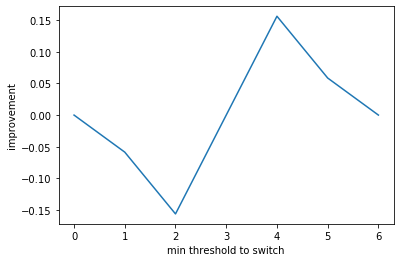

In [29]:
## 07-07-2020
## working example of thresholding
## reproduces hastings' table 1 !! Woohoo!
D=5
outs = gen_pts(D, calc_improvement)
print_best(D, outs)
plot_T(D, outs)

#### 07-07-2020
#### thresholding, admitting at least one triangle
$ <Z_i Z_j> = 1/4 \big( (\sum_k P(k) q(k+2))^2 + (\sum_k P(k) q(k+1))^2 -2 (\sum_k P(k) q(k))(\sum_k P(k) q(k+1))\big) $

In [30]:
def calc_improvement_one_triangle(D, T):
    """This reproduces Hastings' thresholding algorithm including one triangle. It calculates -1/2 <Z_i Z_j>"""
    s1 = 0
    s2 = 0
    s3 = 0
    # go through # agreeing neighbors, from 0 through D-2
    for i in range(D-1):
        # factor out 2^-X
        s1 += binom(D-2, i)*q(i+2, T)
        s2 += binom(D-2, i)*q(i+1, T)
        s3 += binom(D-2, i)*q(i, T)
    return -0.5 * 0.25 * (s1**2 + s2**2 - 2*s2*s3) * 2**(-2*(D-2))

D = 12 T = 8 improvement = 0.0986623764038086
D = 12 T = 8 improvement = 0.08471488952636719


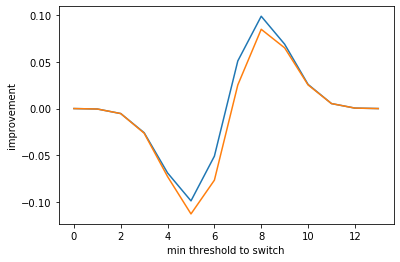

In [31]:
## regular vs with a triangle
D=12
outs = gen_pts(D, calc_improvement)
outs2 = gen_pts(D, calc_improvement_one_triangle)
print_best(D, outs)
print_best(D, outs2)
plot_T(D, outs)
plot_T(D, outs2)

#### N triangles
each term where i=j and term where i!= j, there are l neighbor triangles aligned with i

$ <Z_i Z_j> = \sum_{l=0}^N 0.5 P(l) \Big( \big( \sum_{k=0}^{D-1-N} P(k) q(k+l+1) \big)^2  
-  \big( \sum_{k=0}^{D-1-N} P(k) q(k+l) \big)\big( \sum_{k=0}^{D-1-N} P(k) q(k+N-l) \big ) \Big)$

In [32]:
def calc_improvement_n_triangles(D, T, N):
    p_k_vec = binom(D-1-N, range(D-N))
    out=0
    for l in range(0, N+1):
        q_kl1_vec = q(np.array(range(l+1, D-N + l+1)), T)
        q_kl_vec = q(np.array(range(l, D-N + l)), T)
        q_knl_vec = q(np.array(range(N-l, D-N + N-l)), T)
        l_out = sum(p_k_vec * q_kl1_vec)**2 - sum(p_k_vec * q_kl_vec)*sum(p_k_vec * q_knl_vec)
        l_out *= binom(N, l)
        out += l_out
    return -0.5 * out * 2**(-N - 1) * 2**((-2*(D - 1 - N)))

In [33]:
calc_improvement(5, 2)

-0.15625

In [34]:
calc_improvement_one_triangle(5, 2)

-0.1953125

In [35]:
calc_improvement_n_triangles(5, 2, 0)

-0.15625

In [36]:
calc_improvement_n_triangles(5, 2, 1)

-0.1953125

In [37]:
def calc_improvement_n_triangles_curried(n):
    return lambda d, t: calc_improvement_n_triangles(d, t, n)

D = 7 T = 5 improvement = 0.128173828125
D = 7 T = 6 improvement = 0.056640625


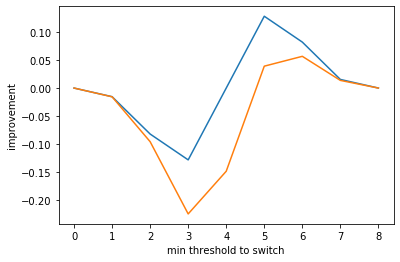

In [39]:
## regular vs with a triangle
D=7
N=3
outs = gen_pts(D, calc_improvement)
outs2 = gen_pts(D, calc_improvement_n_triangles_curried(N))
print_best(D, outs)
print_best(D, outs2)
plot_T(D, outs)
plot_T(D, outs2)